<a href="https://colab.research.google.com/github/krish-94/Exploratory_data_analysis/blob/master/Car_Damage_detection_MRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN
%cd Mask_RCNN
from IPython.display import clear_output
clear_output()

In [ ]:
# https://github.com/matterport/Mask_RCNN/issues/1754#issuecomment-776493501

with open('mrcnn/model.py') as file:
  model_file = file.read()

with open('mrcnn/model.py','w') as f:
  model_file = model_file.replace("self.keras_model = self.build(mode=mode, config=config)",
                                  "self.keras_model = self.build(mode=mode, config=config)\n        self.keras_model.metrics_tensors = []")
  f.write(model_file)

# https://stackoverflow.com/questions/53740577/does-any-one-got-attributeerror-str-object-has-no-attribute-decode-whi
!pip3 install 'h5py==2.10.0' --force-reinstall

clear_output()


In [ ]:
!pip3 install -r requirements.txt
!python3 setup.py install
clear_output()

In [ ]:
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cd ../../
clear_output()

In [ ]:
import os
import sys

# Root directory of the project
ROOT_DIR = os.path.abspath("../")
print('Root dir is', ROOT_DIR)

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn import visualize

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Root dir is /content/Mask_RCNN
... done downloading pretrained model!


In [ ]:
# This class is obtained from coco.py under samples folder in mrcnn

class CustomConfig(Config):
  # Give the configuration a recognizable name
  NAME = "car_damage_detection"

  NUM_CLASSES = 1 + 1 # background + damage
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1 # since I am using colab, i have given 1. If you have higher end GPU, mention accordingly

  # Number of training steps per epoch
  STEPS_PER_EPOCH = 100

  # Skip detections with < 90% confidence
  DETECTION_MIN_CONFIDENCE = 0.9

config = CustomConfig()
#config.display()

In [ ]:
!pip3 install pycocotools
clear_output()
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

# This class is customized from coco.py under samples folder in mrcnn

class CocoDataset(utils.Dataset):
    def load_coco(self, dataset_dir, subset, file_name, class_ids=None, class_map=None):

        coco = COCO(os.path.join(dataset_dir, file_name))
        image_dir = "{}/{}".format(dataset_dir, subset)

        # Load all classes or a subset?
        if not class_ids:
            # All classes
            class_ids = sorted(coco.getCatIds())

        # All images or a subset?
        if class_ids:
            image_ids = []
            for id in class_ids:
                image_ids.extend(list(coco.getImgIds(catIds=[id])))
            # Remove duplicates
            image_ids = list(set(image_ids))
        else:
            # All images
            image_ids = list(coco.imgs.keys())

        # Add classes
        for i in class_ids:
            self.add_class("coco", i, coco.loadCats(i)[0]["name"])

        # Add images
        for i in image_ids:
            self.add_image(
                "coco", image_id=i,
                path=os.path.join(image_dir, coco.imgs[i]['file_name']),
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))
            
    def load_mask(self, image_id):
        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = self.map_source_class_id(
                "coco.{}".format(annotation['category_id']))
            if class_id:
                print(self.image_info)
                m = self.annToMask(annotation, self.image_info[image_id]["height"],
                                   self.image_info[image_id]["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            class_ids = np.array(class_ids, dtype=np.int32)
            return mask, class_ids

    def annToMask(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
        :return: binary mask (numpy 2D array)
        """
        rle = self.annToRLE(ann, height, width)
        m = maskUtils.decode(rle)
        return m

    def annToRLE(self, ann, height, width):
        """
        Convert annotation which can be polygons, uncompressed RLE to RLE.
        :return: binary mask (numpy 2D array)
        """
        segm = ann['segmentation']
        if isinstance(segm, list):
            # polygon -- a single object might consist of multiple parts
            # we merge all parts into one mask rle code
            rles = maskUtils.frPyObjects(segm, height, width)
            rle = maskUtils.merge(rles)
        elif isinstance(segm['counts'], list):
            # uncompressed RLE
            rle = maskUtils.frPyObjects(segm, height, width)
        else:
            # rle
            rle = ann['segmentation']
        return rle

In [ ]:
#mount drive
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

# this creates a symbolic link so that now the path /content/gdrive/MyDrive/ is equal to /mydrive
!ln -s /content/gdrive/MyDrive /mydrive

#list contents in your drive
!ls /mydrive

Mounted at /content/gdrive
ln: failed to create symbolic link '/mydrive/MyDrive': Input/output error
'Colab Notebooks'   contacts   obj_det	 photos


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Train: 59
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Train: 11
[{'id': 0, 'source': 'coco', 'path': '/mydrive/obj_det/car_damage/train/10.jpg', 'width': 1024, 'height': 1024, 'annotations': [{'area': 340.0000000000179, 'bbox': [300, 216, 79, 22], 'category_id': 1, 'id': 0, 'image_id': 0, 'iscrowd': 0, 'segmentation': [[379, 216, 337, 218, 300, 223, 318, 238, 350, 237, 369, 231, 375, 227]]}, {'area': 392.00000000000205, 'bbox': [226, 230, 62, 34], 'category_id': 1, 'id': 1, 'image_id': 0, 'iscrowd': 0, 'segmentation': [[288, 230, 264, 238, 245, 249, 226, 264, 241, 264, 249, 253, 269, 253, 275, 250, 284, 238]]}, {'area': 4365.000000000001, 'bbox': [161, 276, 65, 68], 'category_id': 1, 'id': 2, 'image_id': 0, 'iscrowd': 0, 'segmentation': [[161, 331, 191, 326, 200, 276, 207, 315, 226, 322, 222, 337, 196, 344, 184, 342]]}, {'area': 185.99999999999443, 'bbox': [254, 273

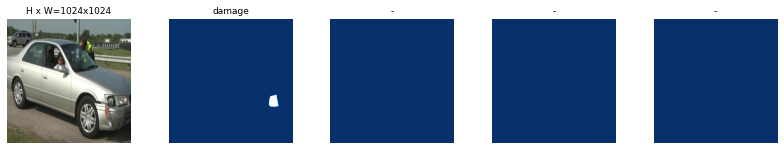

[{'id': 0, 'source': 'coco', 'path': '/mydrive/obj_det/car_damage/train/10.jpg', 'width': 1024, 'height': 1024, 'annotations': [{'area': 340.0000000000179, 'bbox': [300, 216, 79, 22], 'category_id': 1, 'id': 0, 'image_id': 0, 'iscrowd': 0, 'segmentation': [[379, 216, 337, 218, 300, 223, 318, 238, 350, 237, 369, 231, 375, 227]]}, {'area': 392.00000000000205, 'bbox': [226, 230, 62, 34], 'category_id': 1, 'id': 1, 'image_id': 0, 'iscrowd': 0, 'segmentation': [[288, 230, 264, 238, 245, 249, 226, 264, 241, 264, 249, 253, 269, 253, 275, 250, 284, 238]]}, {'area': 4365.000000000001, 'bbox': [161, 276, 65, 68], 'category_id': 1, 'id': 2, 'image_id': 0, 'iscrowd': 0, 'segmentation': [[161, 331, 191, 326, 200, 276, 207, 315, 226, 322, 222, 337, 196, 344, 184, 342]]}, {'area': 185.99999999999443, 'bbox': [254, 273, 67, 26], 'category_id': 1, 'id': 3, 'image_id': 0, 'iscrowd': 0, 'segmentation': [[258, 273, 289, 273, 318, 275, 321, 289, 307, 299, 283, 296, 264, 291, 254, 285]]}, {'area': 5282.0, '

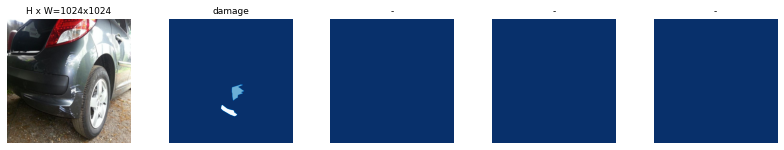

In [ ]:
import numpy as np
dataset_train = CocoDataset()
dataset_train.load_coco('/mydrive/obj_det/car_damage','train','COCO_train_annos.json')
dataset_train.prepare()
print('Train: %d' % len(dataset_train.image_ids))

dataset_val = CocoDataset()
dataset_val.load_coco('/mydrive/obj_det/car_damage','val','COCO_val_annos.json')
dataset_val.prepare()
print('Train: %d' % len(dataset_val.image_ids))

image_ids = np.random.choice(dataset_train.image_ids, 2)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [ ]:
# cerating model for training

import mrcnn.model as modellib

model = modellib.MaskRCNN(mode = "training", config = config, model_dir = MODEL_DIR)

model.load_weights('/content/mask_rcnn_coco.h5', by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])


In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate= 0.001/10,
            epochs=5, 
            layers='heads')

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=0.001 / 10,
            epochs=10, 
            layers="all")

In [ ]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# code from inspect_mode.ipynb under samples/coco folder
import random
image_id = random.choice(dataset_val.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)
info = dataset_val.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset_val.image_reference(image_id)))

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mrcnn.model import log

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

In [ ]:
# ground truth

visualize.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names)

**EVALUATION**

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))